In [7]:
import numpy as np
from scipy.spatial import distance
from scipy.stats import pearsonr

class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):

        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L        
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold   
        

    def shadow_manifold(self, X):
        X = X[:self.L] # make sure we cut at L
        M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold, here t is the time-step index in the original time series
        for t in range((self.E-1) * self.tau, self.L):
            x_lag = [] # lagged values
            for t2 in range(0, self.E-1 + 1): # dimension E
                x_lag.append(X[t-t2*self.tau])               # in each te, calculate values at column 0, 1, E    
            M[t] = x_lag
        return M # the dimension of M should be L-(E-1)*tau by E, each row is a point in the shadow manifold
    


    def get_distances(self, Mx):
        t_vec = [(k, v) for k,v in Mx.items()] #  k is the key and v is the value from the dictionary Mx
        t_steps = np.array([i[0] for i in t_vec]) # the row index
        vecs = np.array([i[1] for i in t_vec]) # the coordinates of the points in the shadow manifold
        dists = distance.cdist(vecs, vecs)    # calculate pairwise distances 
        return t_steps, dists
    


    def get_nearest_distances(self, t, t_steps, dists):

        t_ind = np.where(t_steps == t) # get the index of time t, here the index is for the points in the manifold
        dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)
        
        nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
        nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise 
        nearest_distances = dist_t[nearest_inds]  
        
        return nearest_timesteps, nearest_distances
    


    def predict(self, t):

        eps = 0.000001 # epsilon minimum distance possible
        t_ind = np.where(self.t_steps == t) # get the index of time t
        # dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)    
        nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)    
        
        # get weights
        u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
        w = u / np.sum(u)
        
        # get prediction of X
        X_true = self.X[t] # get corresponding true X
        X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
        X_hat = (w * X_cor).sum() # get X_hat
        
        return X_true, X_hat
    


    def causality(self):
       
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat) 

        x, y = X_true_list, X_hat_list
        r, p = pearsonr(x, y)        

        return r, p
    

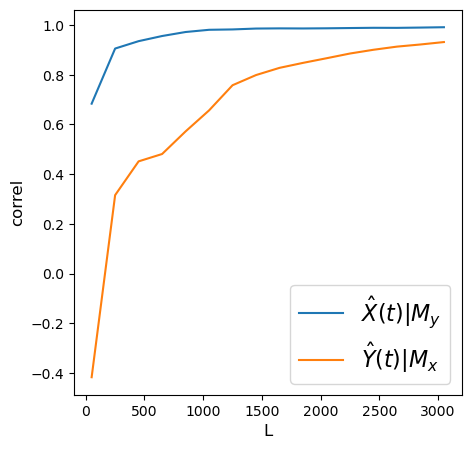

In [8]:
import matplotlib.pyplot as plt

# params
r_x = 3.8
r_y = 3.5
B_xy = 0.02 # effect on x given y (effect of y on x)
B_yx = 0.1 # effect on y given x (effect of x on y)

X0 = 0.4 # initial val
Y0 = 0.2 # initial val
t = 5000 # time steps


def func_1(X, Y, r, B):
    return X*(r - r*X - B*Y)
            

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = func_1(X[-1], Y[-1], r_x, B_xy)
    Y_ = func_1(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)  

# Looking at "convergence"
L_range = range(50, 3200, 200) # L values to test
tau = 1
E = 2

Xhat_My, Yhat_Mx = [], [] # correlation list
for L in L_range: 
    ccm_XY = ccm(X, Y, tau, E, L) # define new ccm object # Testing for X -> Y
    ccm_YX = ccm(Y, X, tau, E, L) # define new ccm object # Testing for Y -> X    
    Xhat_My.append(ccm_XY.causality()[0]) 
    Yhat_Mx.append(ccm_YX.causality()[0]) 
    
# plot convergence as L->inf. Convergence is necessary to conclude causality
plt.figure(figsize=(5,5))
plt.plot(L_range, Xhat_My, label='$\hat{X}(t)|M_y$')
plt.plot(L_range, Yhat_Mx, label='$\hat{Y}(t)|M_x$')
plt.xlabel('L', size=12)
plt.ylabel('correl', size=12)
plt.legend(prop={'size': 16})   

In [6]:
# Mx is a random list of 1000 by 3
Mx = {i: np.random.rand(3) for i in range(1000)}


t_vec = [(k, v) for k,v in Mx.items()]
t_vec[0][0]

0

In [4]:
Mx

{0: array([0.98858057, 0.53641184, 0.00413791]),
 1: array([0.47221212, 0.79313088, 0.07430619]),
 2: array([0.11581712, 0.78064581, 0.87297373]),
 3: array([0.55447125, 0.11734685, 0.31354255]),
 4: array([0.8946298 , 0.9976358 , 0.79602187]),
 5: array([0.9831294 , 0.45758034, 0.48607734]),
 6: array([0.06674908, 0.05242991, 0.77898663]),
 7: array([0.35802867, 0.19102999, 0.7907322 ]),
 8: array([0.41204945, 0.20570592, 0.03513641]),
 9: array([0.94088638, 0.61585995, 0.17706758]),
 10: array([0.00822844, 0.41988672, 0.41730712]),
 11: array([0.08183601, 0.88789302, 0.55937914]),
 12: array([0.39870818, 0.98218353, 0.78003998]),
 13: array([0.19568337, 0.2343793 , 0.73026852]),
 14: array([0.34354685, 0.808586  , 0.01715066]),
 15: array([0.9956012 , 0.83618679, 0.20121734]),
 16: array([0.20828234, 0.52860141, 0.59289075]),
 17: array([0.01184543, 0.49638882, 0.24367581]),
 18: array([0.34633241, 0.73575395, 0.06015424]),
 19: array([0.32604904, 0.36677948, 0.42484142]),
 20: array